### 데이터 불러오기 및 데이터 정제


분석을 위해 사용한 kaggle 데이터셋 링크  
'https://www.kaggle.com/datasets/latifahhukma/fashion-campus'


In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

## _new와의 차이는 특정 데이터를 하나의 칼럼으로 묶는지, 아닌지의 차이가 존재
ck_n_url = '/content/drive/MyDrive/kaggle/cp1/click_stream_new.csv'
customer_url = '/content/drive/MyDrive/kaggle/cp1/customer.csv'
product_url = '/content/drive/MyDrive/kaggle/cp1/product.csv'
ta_n_url = '/content/drive/MyDrive/kaggle/cp1/transaction_new.csv'

In [2]:
ck_n = pd.read_csv(ck_n_url)
customer = pd.read_csv(customer_url)
product = pd.read_csv(product_url, error_bad_lines=False)
ta_n = pd.read_csv(ta_n_url)

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

In [3]:
### Click Stream 데이터 정제
# # 불필요한 column 삭제
# ck = ck_n.drop(columns=['event_id','traffic_source'])

# # 결측치 제거
# zero = ['product_id','quantity', 'item_price', 'promo_amount']
# none_ = ['payment_status','search_keywords', 'promo_code']
# ck[none_] = ck[none_].fillna('None')
# ck[zero] = ck[zero].fillna(0)

# 필요한 데이터만 사용
ck = ck_n[['event_time', 'promo_code', 'session_id','event_name']]

# 시계열 데이터 변환
ck['event_time'] = pd.to_datetime(ck['event_time'])
ck['year'] = ck['event_time'].dt.strftime('%Y')
ck['event_day'] = ck['event_time'].dt.strftime('%Y-%m')

# 데이터 경량화
ck[['event_name', 'promo_code']]\
 = ck[['event_name','promo_code']].astype('category')

# 데이터 정렬
ck = ck.sort_values(by='event_day').reset_index(drop=True)

In [4]:
### Transaction 데이터 정제
# click stream 데이터를 제외한 데이터를 묶음
ta_n = ta_n.query('payment_status == "Success"')
customer = customer[['customer_id' ,'gender', 'birthdate', 'device_type', 'first_join_date']]
ta = pd.merge(ta_n, customer, on = 'customer_id')
product = product.rename(columns = {'id':'product_id'})
products = product[['product_id', 'articleType']]
ta = pd.merge(ta, products, on = 'product_id')

# click stream에서 event 데이터를 session_id로 묶어 ta와 병합
ck_log = pd.DataFrame(ck_n.groupby('session_id')['event_name'].apply(list))
ta = pd.merge(ta, ck_log, on = 'session_id')

# 불필요한 column 삭제
col = ['shipment_location_long','shipment_location_lat', 'payment_status']
ta.drop(columns=col, inplace=True)

# 결측치 제거
ta['promo_code'] = ta['promo_code'].fillna('None')

# 시계열 데이터 변환
ta['created_at'] = pd.to_datetime(ta['created_at'])
ta['first_join_date'] = pd.to_datetime(ta['first_join_date']).dt.strftime('%Y-%m')
ta['birthdate'] = pd.to_datetime(ta['birthdate']).dt.strftime('%Y')
ta['created_year'] = ta['created_at'].dt.strftime('%Y')
ta['created_month'] = ta['created_at'].dt.strftime('%m')
ta['created_day'] = ta['created_at'].dt.strftime('%Y-%m-%d')
ta['created_at'] = ta['created_at'].dt.strftime('%Y-%m')

# 데이터 경량화
ta[['payment_method','promo_code','gender', 'device_type', 'articleType']]\
 = ta[['payment_method','promo_code','gender', 'device_type', 'articleType']].astype('category')

# 데이터 정렬
ta = ta.sort_values(by='created_at').reset_index(drop=True)

## DATA WRANGLING


### 월간 유저 활동 및 프로모션

***월간 유저 활동 이벤트 확인***

In [ ]:
### 월간 유저 활동 이벤트
click = pd.DataFrame(ck.query('event_name == "CLICK"').groupby('event_day')['event_name'].count()).reset_index()
homepage = pd.DataFrame(ck.query('event_name == "HOMEPAGE"').groupby('event_day')['event_name'].count()).reset_index()
add_cart = pd.DataFrame(ck.query('event_name == "ADD_TO_CART"').groupby('event_day')['event_name'].count()).reset_index()
scroll = pd.DataFrame(ck.query('event_name == "SCROLL"').groupby('event_day')['event_name'].count()).reset_index()
item_detail = pd.DataFrame(ck.query('event_name == "ITEM_DETAIL"').groupby('event_day')['event_name'].count()).reset_index()
search = pd.DataFrame(ck.query('event_name == "SEARCH"').groupby('event_day')['event_name'].count()).reset_index()
booking = pd.DataFrame(ck.query('event_name == "BOOKING"').groupby('event_day')['event_name'].count()).reset_index()
promo_page = pd.DataFrame(ck.query('event_name == "PROMO_PAGE"').groupby('event_day')['event_name'].count()).reset_index()
add_promo = pd.DataFrame(ck.query('event_name == "ADD_PROMO"').groupby('event_day')['event_name'].count()).reset_index()

log_data = pd.merge(click, homepage, on = 'event_day').rename(columns={'event_name_x' : 'click', 'event_name_y':'homepage'})
event_list = [add_cart, scroll, item_detail, search, booking, promo_page, add_promo]
event_name = ['add_cart', 'scroll', 'item_detail', 'search', 'booking', 'promo_page', 'add_promo']
for e, n in zip(event_list, event_name) :
    log_data = pd.merge(log_data, e, on='event_day').rename(columns={'event_name' : n})

### 월간 가입 유저 수
customer['first_join_date'] = pd.to_datetime(customer['first_join_date'])
customer['first_join_date'] = customer['first_join_date'].dt.strftime('%Y-%m')
cu = pd.DataFrame(customer.groupby('first_join_date')['customer_id'].count()).reset_index()
cu = cu.rename(columns={'first_join_date': 'event_day', 'customer_id':'join_count'})

### 월간 매출
sales = ta.groupby('created_at')['total_amount'].sum().reset_index()
sales = sales.rename(columns={'created_at':'event_day'})

### 데이터 병합
timeline_data = pd.merge(log_data, cu, on='event_day')
timeline_data = pd.merge(timeline_data, sales, on='event_day')
timeline_data[['total_user','year','month']] = None
for i in range(len(timeline_data)) :
    if not i :
        timeline_data['total_user'][i] = timeline_data['join_count'][i]
    else :
        timeline_data['total_user'][i] = timeline_data['join_count'][i] + timeline_data['total_user'][i-1]
    timeline_data['year'][i] = timeline_data['event_day'][i].split('-')[0]
    timeline_data['month'][i] = timeline_data['event_day'][i].split('-')[1]
timeline_data['booking_avg_amount'] = (timeline_data['total_amount'] / timeline_data['booking']).astype(int)
timeline_data['user_avg_amount'] = (timeline_data['total_amount'] / timeline_data['total_user']).astype(int)
timeline_data

,event_day,click,homepage,add_cart,scroll,item_detail,search,booking,promo_page,add_promo,join_count,total_amount,total_user,year,month,booking_avg_amount,user_avg_amount
0,2016-07,783,809,881,443,355,341,296,230,193,825,398447595,825,2016,07,1346106,482966
1,2016-08,1561,1525,1668,1030,779,700,547,447,276,720,1323589124,1545,2016,08,2419724,856691
2,2016-09,2257,2456,2224,1474,1135,985,717,633,351,751,1333866878,2296,2016,09,1860344,580952
3,2016-10,3006,2999,2946,1939,1437,1269,989,864,445,881,1899105619,3177,2016,10,1920228,597766
4,2016-11,3569,3493,3354,2264,1715,1562,1157,980,538,764,1304801169,3941,2016,11,1127745,331083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,2022-03,87797,84287,59691,58974,45523,41748,28801,19880,9253,1954,48253779324,91868,2022,03,1675420,525251
69,2022-04,89425,86069,59258,60786,46487,43413,29237,19926,9397,2019,48606858023,93887,2022,04,1662511,517716
70,2022-05,91938,89005,58892,62491,47339,44623,30084,20707,9492,2054,49924336672,95941,2022,05,1659497,520364
71,2022-06,92407,86186,50617,62689,47358,45010,28587,20093,8297,1851,46797570226,97792,2022,06,1637022,478541


***월별 프로모션 이용 비율***

In [ ]:
ta_2022 = ta.query('created_year == "2022"')
ta_2022_col = ['customer_id', 'created_at', 'booking_id', 'promo_amount', 'promo_code', 'shipment_fee', 'session_id',
                'total_amount', 'product_id', 'quantity', 'item_price', 'gender', 'birthdate', 'first_join_date', 
                'articleType', 'event_name', 'created_day']
ta_2022 = ta_2022[ta_2022_col]
month_22 = sorted(list(set(ta_2022['created_at'])))

In [ ]:
## promotion 이용 비율
promo22 = pd.DataFrame((ta_2022.query('created_at == "2022-01"'))['promo_code'].value_counts(normalize=True))
promo22 = promo22.reset_index().rename(columns={'promo_code' : '2022-01'})
month22_alpha = month_22[1:]
for i in month22_alpha :
  a = pd.DataFrame((ta_2022.query(f'created_at == "{i}"'))['promo_code'].value_counts(normalize=True))
  a = a.reset_index().rename(columns={'promo_code' : str(i)})
  promo22 = pd.merge(promo22, a, on = 'index')
promo22 = promo22.set_index('index').T.reset_index().rename(columns={'index':'month'})
promo22['promo_total'] = promo22['AZ2022'] + promo22['WEEKENDSERU'] + promo22['BUYMORE'] + \
                        promo22['LIBURDONG'] + promo22['SC2022'] + promo22['STARTUP'] + \
                        promo22['WEEKENDMANTAP'] + promo22['XX2022']
promo22

index,month,None,AZ2022,WEEKENDSERU,BUYMORE,XX2022,LIBURDONG,WEEKENDMANTAP,SC2022,STARTUP,promo_total
0,2022-01,0.656176,0.087233,0.071432,0.068026,0.043499,0.025366,0.025156,0.011661,0.011451,0.343824
1,2022-02,0.675468,0.087847,0.061273,0.068495,0.043021,0.019042,0.020509,0.012243,0.012102,0.324532
2,2022-03,0.670029,0.092808,0.057246,0.069464,0.048672,0.018239,0.019528,0.012465,0.011548,0.329971
3,2022-04,0.669902,0.091818,0.059437,0.069601,0.044433,0.021926,0.019385,0.011907,0.011592,0.330098
4,2022-05,0.677744,0.085060,0.061270,0.070073,0.042790,0.022186,0.019117,0.011116,0.010644,0.322256
5,2022-06,0.688008,0.087327,0.054533,0.066607,0.044049,0.018087,0.017515,0.012198,0.011677,0.311992
6,2022-07,0.723522,0.071089,0.056809,0.054570,0.039242,0.018105,0.017340,0.009690,0.009633,0.276478


### VVIP, VIP, 우수고객, 일반고객 비교

***VVIP, VIP, 우수 고객, 일반 고객 구매 활동 확인***

In [ ]:
## 우수 고객, vip, vvip 기준 선정
mean = 0
month_list = set(ta.query('created_year == "2021"')['created_at'])
for i in month_list :
    mean += (ta.query(f'created_at == "{i}"').groupby('customer_id')['total_amount'].sum()).quantile(0.8)
mean /= len(month_list)

vip_mean = 0
for i in month_list :
    vip_mean += (ta.query(f'created_at == "{i}"').groupby('customer_id')['total_amount'].sum()).quantile(0.9)
vip_mean /= len(month_list)

vvip_mean = 0
for i in month_list :
    vvip_mean += (ta.query(f'created_at == "{i}"').groupby('customer_id')['total_amount'].sum()).quantile(0.99)
vvip_mean /= len(month_list)

In [ ]:
### 우수 고객, vip, vvip 관련 데이터 생성
"""
count = 해당 고객군의 고객 수
frequency = 월 평균 구매 건수
precent = 전체 구매 고객 중 고객 군의 고객 비율
avg_amount = 각 고객군의 평균 구매액
"""
vip_by_sales = []
for mon in month_22 :
  a = pd.DataFrame(ta_2022.query(f'created_at == "{mon}"').groupby('customer_id')['total_amount'].sum())
  a = a.reset_index()
  a_ = pd.DataFrame(ta_2022.query(f'created_at == "{mon}"').groupby('customer_id')['total_amount'].count())
  a_ = a_.reset_index().rename(columns={'total_amount' : 'frequency'})
  b = a.query(f'total_amount >= {mean}')
  b_v = b.query(f'total_amount >= {vip_mean}')
  b_i = b.query(f'total_amount < {vip_mean}')
  b_vv = b_v.query(f'total_amount >= {vvip_mean}')
  b_v = b_v.query(f'total_amount < {vvip_mean}')
  b_vv = pd.merge(b_vv, a_, on = 'customer_id')
  b_v = pd.merge(b_v, a_, on = 'customer_id')
  b_i = pd.merge(b_i, a_, on = 'customer_id')
  c = a.query(f'total_amount < {mean}')
  c = pd.merge(c, a_, on = 'customer_id')
  value = [mon, 
           c.shape[0], sum(c['frequency'])/c.shape[0], 
           round(c.shape[0] / a.shape[0], 3), int(sum(c['total_amount'])/c.shape[0]),
           b_i.shape[0], sum(b_i['frequency'])/b_i.shape[0], 
           round(b_i.shape[0]/a.shape[0], 3), int(sum(b_i['total_amount'])/b_i.shape[0]),
           b_v.shape[0], sum(b_v['frequency'])/b_v.shape[0], 
           round(b_v.shape[0]/a.shape[0], 3), int(sum(b_v['total_amount'])/b_v.shape[0]),
           b_vv.shape[0], sum(b_vv['frequency'])/b_vv.shape[0], 
           round(b_vv.shape[0]/a.shape[0], 3), int(sum(b_vv['total_amount'])/b_vv.shape[0])]
  vip_by_sales.append(value)

vip_by_sales = pd.DataFrame(vip_by_sales, columns=['month', 'normal_count', 'normal_frequency', 'normal_percent', 'normal_avg_amount',
                                 'ip_count', 'ip_frequency', 'ip_percent', 'ip_avg_amount',
                                 'vip_count', 'vip_frequency', 'vip_percent', 'vip_avg_amount',
                                 'vvip_count', 'vvip_frequency', 'vvip_percent', 'vvip_avg_amount'])

***vvip, vip, 우수고객에 대한 코호트 분석***


> 구매를 진행한 고객(vvip, vip, 우수)의 7월 리텐션이 감소한 모습을 확인할 수 있다.

  
리텐션 감소의 원인은 해당 데이터를 통해 파악하기 어려울 것이라 판단된다. 만일 구매 고객의 서비스 내 활동이 감소하였을 경우, 외부적인 요인이 작용했을 것이라 판단할 수 있다.

In [ ]:
### vvip, vip, 우수 고객에 대한 2022년도 거래 데이터 프레임 생성
ta_2021 = pd.DataFrame(ta.query('created_year == "2021"').groupby('customer_id')['total_amount'].sum())
ta_2021 = ta_2021.reset_index()
ip_2021 = ta_2021.query(f'total_amount >= {mean}')
vip_2021 = ip_2021.query(f'total_amount >= {vip_mean}')
vvip_2021 = vip_2021.query(f'total_amount >= {vvip_mean}').drop(columns=['total_amount'])
vip_2021 = vip_2021.query(f'total_amount < {vvip_mean}').drop(columns=['total_amount'])
ip_2021 = ip_2021.query(f'total_amount < {vip_mean}').drop(columns=['total_amount'])

vvip_2021 = pd.merge(vvip_2021, ta_2022, on = 'customer_id')
vip_2021 = pd.merge(vip_2021, ta_2022, on = 'customer_id')
ip_2021 = pd.merge(ip_2021, ta_2022, on = 'customer_id')

In [ ]:
### 코호트 분석을 위해 필요한 column만 저장, customer_id를 인덱스로 저장
vvip_cohort = vvip_2021[['customer_id', 'created_at', 'booking_id', 'created_day']].set_index('customer_id')
vip_cohort = vip_2021[['customer_id', 'created_at', 'booking_id', 'created_day']].set_index('customer_id')
ip_cohort = ip_2021[['customer_id', 'created_at', 'booking_id', 'created_day']].set_index('customer_id')

### customer_id를 기준으로 각 id별 첫 주문을 first_order column에 저장하고 
### 첫 주문 날짜와 이후 주문날짜, 각 기간별 총 구매 고객 수를 저장
vvip_first_order = vvip_cohort.groupby(vvip_cohort.index)['created_day'].min()
vvip_first_order = pd.to_datetime(vvip_first_order).dt.strftime('%Y-%m')
vvip_cohort['first_order'] = vvip_first_order
vvip_cohort.reset_index(inplace=True)
vvip_group = vvip_cohort.groupby(['first_order', 'created_at'])
vvip_cohorts = vvip_group['customer_id'].nunique().reset_index()
vvip_cohorts = vvip_cohorts.rename(columns={'customer_id' : 'total_customer'})

vip_first_order = vip_cohort.groupby(vip_cohort.index)['created_day'].min()
vip_first_order = pd.to_datetime(vip_first_order).dt.strftime('%Y-%m')
vip_cohort['first_order'] = vip_first_order
vip_cohort.reset_index(inplace=True)
vip_group = vip_cohort.groupby(['first_order', 'created_at'])
vip_cohorts = vip_group['customer_id'].nunique().reset_index()
vip_cohorts = vip_cohorts.rename(columns={'customer_id' : 'total_customer'})

ip_first_order = ip_cohort.groupby(ip_cohort.index)['created_day'].min()
ip_first_order = pd.to_datetime(ip_first_order).dt.strftime('%Y-%m')
ip_cohort['first_order'] = ip_first_order
ip_cohort.reset_index(inplace=True)
ip_group = ip_cohort.groupby(['first_order', 'created_at'])
ip_cohorts = ip_group['customer_id'].nunique().reset_index()
ip_cohorts = ip_cohorts.rename(columns={'customer_id' : 'total_customer'})

vvip_cohorts.head()

,first_order,created_at,total_customer
0,2022-01,2022-01,2291
1,2022-01,2022-02,2057
2,2022-01,2022-03,2145
3,2022-01,2022-04,2147
4,2022-01,2022-05,2119


In [ ]:
### 모든 경우의 수([01-01] ~ [07-07])에 대해 없는 날짜를 파악하여 0의 값을 저장
period = [[month_22[i], month_22[j]] for i in range(len(month_22)) for j in range(len(month_22)) if i <= j]
empty_period = []
for i in range(len(vvip_cohorts)) :
  v = [vvip_cohorts.first_order[i], vvip_cohorts.created_at[i]]
  if v in period :
    empty_period.append(v)
vvip_empty_period = [p for p in period if p not in empty_period]

empty_period = []
for i in range(len(vip_cohorts)) :
  v = [vip_cohorts.first_order[i], vip_cohorts.created_at[i]]
  if v in period :
    empty_period.append(v)
vip_empty_period = [p for p in period if p not in empty_period]

empty_period = []
for i in range(len(ip_cohorts)) :
  v = [ip_cohorts.first_order[i], ip_cohorts.created_at[i]]
  if v in period :
    empty_period.append(v)
ip_empty_period = [p for p in period if p not in empty_period]

for value in vvip_empty_period :
  vvip_cohorts.loc[vvip_cohorts.shape[0], 'first_order'] = value[0]
  vvip_cohorts.loc[vvip_cohorts.shape[0]-1, 'created_at'] = value[1]
  vvip_cohorts.loc[vvip_cohorts.shape[0]-1, 'total_customer'] = 0

for value in vip_empty_period :
  vip_cohorts.loc[vip_cohorts.shape[0], 'first_order'] = value[0]
  vip_cohorts.loc[vip_cohorts.shape[0]-1, 'created_at'] = value[1]
  vip_cohorts.loc[vip_cohorts.shape[0]-1, 'total_customer'] = 0

for value in ip_empty_period :
  ip_cohorts.loc[ip_cohorts.shape[0], 'first_order'] = value[0]
  ip_cohorts.loc[ip_cohorts.shape[0]-1, 'created_at'] = value[1]
  ip_cohorts.loc[ip_cohorts.shape[0]-1, 'total_customer'] = 0

vvip_cohorts.sort_values(by =['first_order', 'created_at'], inplace=True)
vip_cohorts.sort_values(by =['first_order', 'created_at'], inplace=True)
ip_cohorts.sort_values(by =['first_order', 'created_at'], inplace=True)

In [ ]:
### 코호트 시각화를 위한 데이터 프레임 형성
period = vvip_cohorts['first_order'].value_counts().sort_index()
period_index = [i for v in period for i in range(v)]
vvip_cohorts['cohort_period'] = period_index
vip_cohorts['cohort_period'] = period_index
ip_cohorts['cohort_period'] = period_index

vvip_retention = vvip_cohorts.set_index(['first_order', 'cohort_period'])
vip_retention = vip_cohorts.set_index(['first_order', 'cohort_period'])
ip_retention = ip_cohorts.set_index(['first_order', 'cohort_period'])

vvip_retention = vvip_retention['total_customer'].unstack(1)
vip_retention = vip_retention['total_customer'].unstack(1)
ip_retention = ip_retention['total_customer'].unstack(1)

vvip_retention_rate = vvip_retention.divide(vvip_retention[0], axis=0)
vip_retention_rate = vip_retention.divide(vip_retention[0], axis=0)
ip_retention_rate = ip_retention.divide(ip_retention[0], axis=0)

In [ ]:
vvip_retention[0]

first_order
2022-01    2291.0
2022-02     220.0
2022-03      72.0
2022-04      22.0
2022-05       3.0
2022-06       0.0
2022-07       0.0
Name: 0, dtype: float64

In [ ]:
sum(vip_retention[0][:3]) / sum(vip_retention[0])

0.961275415896488

In [ ]:
sum(ip_retention[0][:3]) / sum(ip_retention[0])

0.9157751410231473

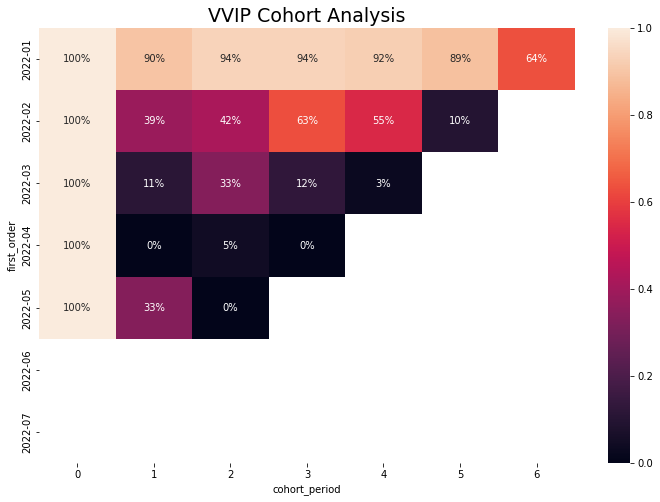

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('VVIP Cohort Analysis', fontsize=19)
sns.heatmap(vvip_retention_rate, annot=True, fmt='.0%')
plt.show()

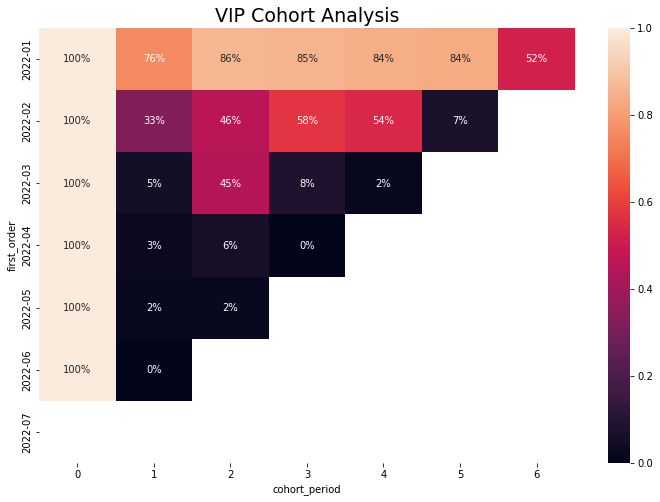

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('VIP Cohort Analysis', fontsize=19)
sns.heatmap(vip_retention_rate, annot=True, fmt='.0%')
plt.show()

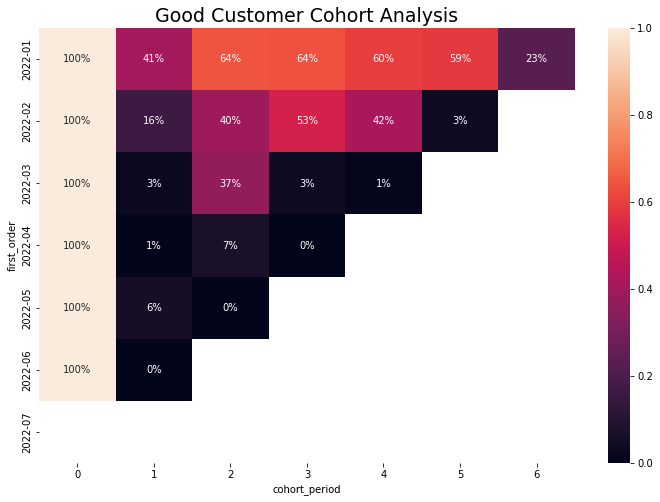

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Good Customer Cohort Analysis', fontsize=19)
sns.heatmap(ip_retention_rate, annot=True, fmt='.0%')
plt.show()

***VIP 고객 및 우수 고객 활동 로그 분석***


> 구매를 진행한 고객(일반, 우수, vip, vvip)의 서비스 내 활동이 감소한 것을 확인할 수 있다  
  
구매를 하지 않은 고객의 서비스 내 활동이 이전보다 증가하였다고 판단할 수 있다.








In [ ]:
### VVIP, VIP 고객과 우수 고객의 아이디로 이루어진 event_name을 추출
ck_2022 = ck.query('year == "2022"')
ck_2022 = ck_2022[['session_id', 'event_name', 'event_day']]
vvip_2021_log = vvip_2021[['created_at', 'session_id']]
vip_2021_log = vip_2021[['created_at', 'session_id']]
ip_2021_log = ip_2021[['created_at', 'session_id']]
vvip_2021_log = pd.merge(vvip_2021_log, ck_2022, on = 'session_id')
vip_2021_log = pd.merge(vip_2021_log, ck_2022, on = 'session_id')
ip_2021_log = pd.merge(ip_2021_log, ck_2022, on = 'session_id')
vvip_2021_log = vvip_2021_log.sort_values(by = 'event_day')
vip_2021_log = vip_2021_log.sort_values(by = 'event_day')
ip_2021_log = ip_2021_log.sort_values(by = 'event_day')

In [ ]:
### 고객의 활동을 활성 정도를 추정할 수 있는 click과 homepage에 대한 활동로그를 별도로 저장
vvip_click = pd.DataFrame(vvip_2021_log.query('event_name == "CLICK"').groupby('event_day')['event_name'].count()).reset_index()
vvip_homepage = pd.DataFrame(vvip_2021_log.query('event_name == "HOMEPAGE"').groupby('event_day')['event_name'].count()).reset_index()
vvip_log_data = pd.merge(vvip_click, vvip_homepage, on = 'event_day')
vvip_log_data = vvip_log_data.rename(columns={'event_name_x' : 'click', 'event_name_y' : 'homepage'})

vip_click = pd.DataFrame(vip_2021_log.query('event_name == "CLICK"').groupby('event_day')['event_name'].count()).reset_index()
vip_homepage = pd.DataFrame(vip_2021_log.query('event_name == "HOMEPAGE"').groupby('event_day')['event_name'].count()).reset_index()
vip_log_data = pd.merge(vip_click, vip_homepage, on = 'event_day')
vip_log_data = vip_log_data.rename(columns={'event_name_x' : 'click', 'event_name_y' : 'homepage'})

ip_click = pd.DataFrame(ip_2021_log.query('event_name == "CLICK"').groupby('event_day')['event_name'].count()).reset_index()
ip_homepage = pd.DataFrame(ip_2021_log.query('event_name == "HOMEPAGE"').groupby('event_day')['event_name'].count()).reset_index()
ip_log_data = pd.merge(ip_click, ip_homepage, on = 'event_day')
ip_log_data = ip_log_data.rename(columns={'event_name_x' : 'click', 'event_name_y' : 'homepage'})

In [ ]:
### 일반 고객에 대한 활동로그
vvip_customer = set(vvip_2021['session_id'].tolist())
vip_customer = set(vip_2021['session_id'].tolist())
ip_customer = set(ip_2021['session_id'].tolist())
normal_customer = set(ck_2022['session_id'].tolist()) - vvip_customer \
                  - vip_customer - ip_customer
normal_customer = pd.DataFrame(normal_customer, columns = ['session_id'])
normal_log = pd.merge(normal_customer, ck_2022, on = 'session_id')
normal_click = pd.DataFrame(vvip_2021_log.query('event_name == "CLICK"').groupby('event_day')['event_name'].count()).reset_index()
normal_homepage = pd.DataFrame(vvip_2021_log.query('event_name == "HOMEPAGE"').groupby('event_day')['event_name'].count()).reset_index()
normal_log_data = pd.merge(normal_click, normal_homepage, on = 'event_day')
normal_log_data = normal_log_data.rename(columns={'event_name_x' : 'click', 'event_name_y' : 'homepage'})
normal_log_data

,event_day,click,homepage
0,2022-01,27506,25817
1,2022-02,27007,24487
2,2022-03,27169,24457
3,2022-04,26419,24791
4,2022-05,28080,26857
5,2022-06,25656,23210
6,2022-07,19708,16133


In [ ]:
vvip_log_data

,event_day,click,homepage
0,2022-01,27506,25817
1,2022-02,27007,24487
2,2022-03,27169,24457
3,2022-04,26419,24791
4,2022-05,28080,26857
5,2022-06,25656,23210
6,2022-07,19708,16133


In [ ]:
vip_log_data

,event_day,click,homepage
0,2022-01,57469,52278
1,2022-02,51797,47206
2,2022-03,56947,53755
3,2022-04,53612,51582
4,2022-05,57484,53511
5,2022-06,53814,50654
6,2022-07,33467,29031


In [ ]:
ip_log_data

,event_day,click,homepage
0,2022-01,10202,9757
1,2022-02,9298,9861
2,2022-03,11904,12431
3,2022-04,11300,13011
4,2022-05,10536,11411
5,2022-06,8477,8940
6,2022-07,4286,3433


***vip-우수 고객의 프로모션 이용 비율 차이***

In [ ]:
promo_col = ['None', 'AZ2022', 'BUYMORE', 'WEEKENDSERU', 'XX2022', 
             'LIBURDONG', 'WEEKENDMANTAP','SC2022', 'STARTUP']
vip_customer = vip_2021[['customer_id', 'promo_code']]
ip_customer = ip_2021[['customer_id', 'promo_code']]
pr_vip = []
pr_ip = []
for mon in month_22 :
  t = ta_2022.query(f'created_at == "{mon}"')
  t = t[['customer_id', 'created_at']]
  t_v = pd.merge(vip_customer, t, on = 'customer_id')
  t_i = pd.merge(ip_customer, t, on = 'customer_id')
  a = pd.DataFrame(t_v['promo_code'].value_counts(normalize=True))
  b = pd.DataFrame(t_i['promo_code'].value_counts(normalize=True))
  p_v = a.T.iloc[:, :].values.tolist()
  p_n = b.T.iloc[:, :].values.tolist()
  pr_vip += p_v
  pr_ip += p_n

pr_vip = pd.DataFrame(pr_vip, index = month_22, columns=promo_col).reset_index()
pr_ip = pd.DataFrame(pr_ip, index = month_22, columns=promo_col).reset_index()

In [ ]:
pr_vip

,index,None,AZ2022,BUYMORE,WEEKENDSERU,XX2022,LIBURDONG,WEEKENDMANTAP,SC2022,STARTUP
0,2022-01,0.673096,0.085407,0.070653,0.059227,0.043938,0.022328,0.022078,0.012543,0.010731
1,2022-02,0.678838,0.090467,0.067715,0.058056,0.040669,0.020760,0.019388,0.013117,0.010991
2,2022-03,0.677668,0.085286,0.068872,0.059246,0.045398,0.020987,0.018678,0.012552,0.011313
3,2022-04,0.681344,0.089100,0.068306,0.057781,0.038675,0.019686,0.019570,0.014457,0.011082
4,2022-05,0.686960,0.083362,0.069088,0.055846,0.041158,0.022352,0.019270,0.011429,0.010536
5,2022-06,0.683399,0.087394,0.066976,0.058823,0.041301,0.021001,0.018708,0.011457,0.010939
6,2022-07,0.687252,0.084358,0.066407,0.057181,0.042002,0.020465,0.019467,0.011658,0.011210


In [ ]:
pr_ip

,index,None,AZ2022,BUYMORE,WEEKENDSERU,XX2022,LIBURDONG,WEEKENDMANTAP,SC2022,STARTUP
0,2022-01,0.695681,0.077053,0.058483,0.051376,0.037933,0.033202,0.019186,0.018504,0.008581
1,2022-02,0.705861,0.089334,0.057355,0.047907,0.045060,0.021622,0.014284,0.009817,0.008762
2,2022-03,0.680374,0.092739,0.064063,0.059162,0.038824,0.029327,0.019239,0.009111,0.007159
3,2022-04,0.683051,0.093262,0.062509,0.053299,0.051397,0.022952,0.014404,0.011177,0.007950
4,2022-05,0.701358,0.071467,0.065663,0.048437,0.039558,0.037323,0.015032,0.013740,0.007424
5,2022-06,0.687679,0.086743,0.063990,0.060720,0.045097,0.022481,0.013920,0.010695,0.008674
6,2022-07,0.710636,0.081292,0.059994,0.043078,0.040011,0.031377,0.014549,0.010824,0.008239


### 개인 상품 추천 서비스

***개인 상품 추천 서비스***


> 소비자가 원하는 상품이 없어서 활성화가 안되는 경우 새로운 상품을 런칭할 수 있고, 원하는 상품을 찾지 못하는 경우 개인화된 추천 서비스를 제공할 수 있다.



In [9]:
### RAM 용량으로 인해 별도의 런타임에서 진행 필요! ###
product = pd.read_csv(product_url, error_bad_lines=False)
products = product.sort_values(by = 'year', ascending = False)
products['productDisplayName'] = products['productDisplayName'].fillna(products['articleType'])

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

In [3]:
### 상품의 출시연도를 확인
products_year = pd.DataFrame(products['year'].value_counts()).reset_index()
products_year = products_year.sort_values('index')
products_year.head()

,index,year
12,2007.0,2
11,2008.0,7
10,2009.0,20
6,2010.0,846
1,2011.0,13672


In [4]:
products_year.tail()

,index,year
4,2015.0,2780
2,2016.0,6006
3,2017.0,2916
7,2018.0,405
9,2019.0,33


In [10]:
# RAM용량 부족으로 인해 최근 10년 상품(2013년 이후 상품)에 대해서만 추천 서비스 제작
products_recent = products.query('year >= 2013')
products_recent.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
44051,55270,Women,Personal Care,Makeup,Kajal and Eyeliner,Black,Summer,2019.0,Casual,Lakme Insta-Liner
26769,55238,Women,Personal Care,Makeup,Foundation and Primer,Skin,Summer,2019.0,Casual,Lakme Invisible Finish 04 Foundation
8173,55978,Women,Personal Care,Lips,Lipstick,Orange,Summer,2019.0,Casual,Colorbar Velvet Matte Obsessed Orange Lipstick...
28936,56167,Women,Personal Care,Makeup,Kajal and Eyeliner,Black,Summer,2019.0,Casual,Colorbar Precision Waterproof Eye Liner
20997,55227,Women,Personal Care,Makeup,Foundation and Primer,Skin,Summer,2019.0,Casual,Lakme Absolute White Intense Skin Cover Ivory ...


In [15]:
### TF-IDF 방식으로 상품 명을 기반으로 유사한 상품을 추천
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf = TfidfVectorizer() # stop_words='english'
tfidf_matrix = tfidf.fit_transform(products_recent['productDisplayName'])

id2products = {}
products2id = {}
for id, pro in enumerate(products_recent['productDisplayName']) :
  id2products[id] = pro
  products2id[pro] = id

def get_similar(score, idx, top = 10) :
  score = [(i, v) for i, v in enumerate(score[idx]) if i != idx]
  score = sorted(score, key = lambda x : x[1], reverse=True)
  score = [[id2products[i], s] for i, s in score[0:top]]
  score = pd.DataFrame(score, columns=['product', 'similar_score'])
  return score

cosine_score = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [16]:
product_idx = products2id['Lakme Insta-Liner']
get_similar(cosine_score, product_idx, top=15)

,product,similar_score
0,Lakme Black Impact Eye Liner,0.345570
1,Lakme Absolute Shine Line Black Eye Liner,0.310844
2,Lakme Absolute Shine Line Olive Eye Liner,0.293472
3,Lakme Women Absolute Precision Liquid Eye Liner,0.291716
4,Lakme Absolute Shine Line Brown Shimmer Eye Liner,0.277722
5,Lakme Fantasy Glimmer Blue Shimmer Eye Liner,0.267610
6,Lakme Absolute Shine Line Smoky Grey Eye Liner,0.264421
7,Lakme Absolute Forever Silk Poppy Red Lip Liner,0.262994
8,Lakme Absolute Forever Silk Blacklast Eye Liner,0.262645
9,Lakme Absolute Forever Silk Blue Cosmos Eye Liner,0.257993


### 데이터 내보내기

In [ ]:
tl_data = timeline_data[['event_day', 'click', 'homepage', 'add_cart', 'scroll',
                         'item_detail', 'search','booking', 'promo_page', 'add_promo',
                         'join_count','total_amount', 'total_user', 'booking_avg_amount',
                         'user_avg_amount']]
tl_data = tl_data.rename(columns={'event_day' : 'month'})

In [ ]:
# pr_vip.to_csv('/content/drive/MyDrive/kaggle/cp1/pr_vip.csv', index=False)
# pr_ip.to_csv('/content/drive/MyDrive/kaggle/cp1/pr_ip.csv', index=False)
vip_by_sales.to_csv('/content/drive/MyDrive/kaggle/cp1/vip_by_sales.csv', index=False)
vip_log_data.to_csv('/content/drive/MyDrive/kaggle/cp1/vip_log_data.csv', index=False)
ip_log_data.to_csv('/content/drive/MyDrive/kaggle/cp1/ip_log_data.csv', index=False)
tl_data.to_csv('/content/drive/MyDrive/kaggle/cp1/tl_data.csv', index=False)
# products_year.to_csv('/content/drive/MyDrive/kaggle/cp1/products_year.csv', index=False)